In [4]:
import numpy as np
import pandas as pd
import math
import itertools 
from scipy import stats
import time

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation
from prophet.plot import plot_cross_validation_metric, plot, plot_components

## Forecasting Pipeline

In [5]:
sale_df = pd.read_csv(r"C:\Users\cecil\OneDrive\Desktop\Projects\data\timesales_train.csv") 
sale_df

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [6]:
prod_total_sale= pd.to_datetime(sale_df['date'])

#Total Sales Revenue 
prod_total_sale = sale_df.groupby(by = ['date', 'family']).agg({'sales': 'sum'}).reset_index().sort_values(by = ['family', 'date'])

#Changing long to wide-format
prod_sales = prod_total_sale.pivot(index="date", columns="family", values="sales")
prod_sales.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.58900,0.0,186.0,143.0,71.09000,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.31900,0.0,74629.0,23381.0,15754.50000,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002
2013-01-03,161.0,0.0,125.0,52105.0,0.0,18456.48002,0.0,55893.0,18001.0,11172.45500,...,0.0,16597.398113,12568.0,0.0,0.0,10674.393983,3591.388005,0.0,0.0,1094.310994
2013-01-04,169.0,0.0,133.0,54167.0,0.0,16721.96901,0.0,52064.0,18148.0,10143.20900,...,0.0,21625.963055,11303.0,0.0,0.0,10772.515038,4472.965990,0.0,0.0,1293.120995
2013-01-05,342.0,0.0,191.0,77818.0,0.0,22367.76108,0.0,70128.0,23082.0,13734.94501,...,0.0,20879.091050,16819.0,0.0,0.0,13475.009055,5830.073020,0.0,0.0,1245.637004


### Data Cleaning
There are a few methods to account for when cleaning data:

1. Remove low-volume data that can't be used for predictions (Visually inspect or count data)
2. Remove outliers in data (Can perform z-score standardization and drop outliers, or Prophet can naturally deal by inputation, predicting values)
3. Analyze then Deal with missing data (testing randomness, dropping, inputing, etc.) 

We would like categories which have higher sales volumes to use for our models. The range for outliers 3 standard deviations from the mean will be removed, which is outside of 99.7% of the data to reduce model bias. We noticed that in our earlier EDA that there are abnormal dips in data near the end of December, which are outliers.

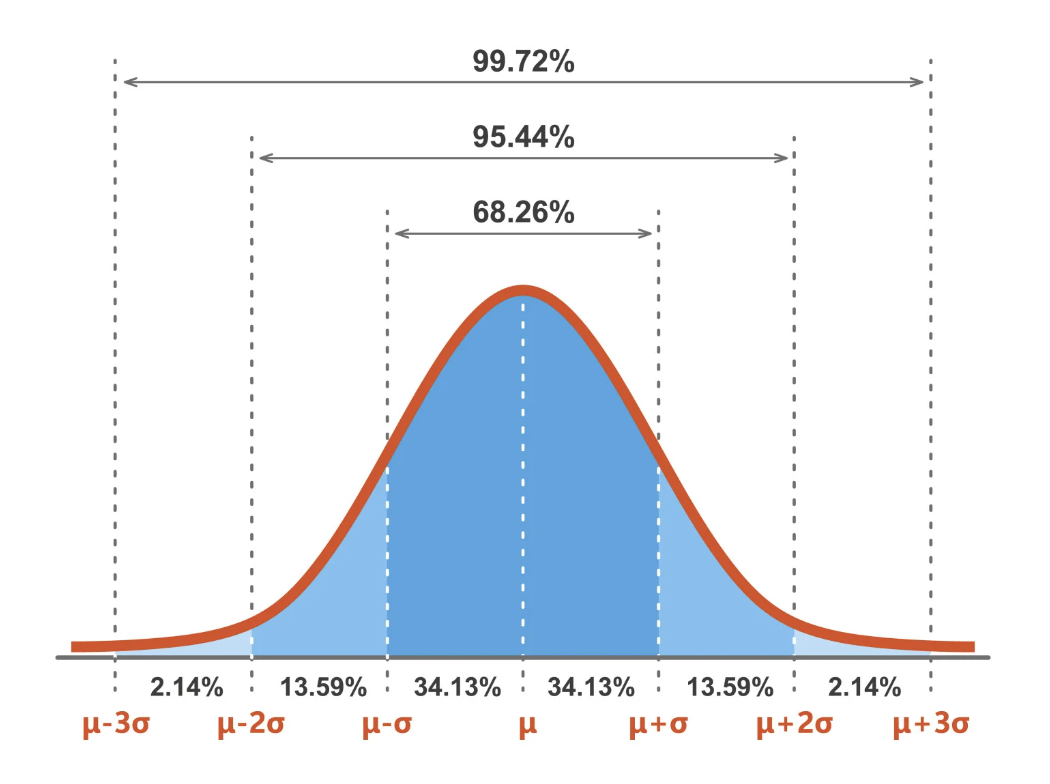

In [7]:
#Drop categories Where mean sales is less than $1000
col_to_drop = prod_sales.columns[(prod_sales.mean() < 1000)]
prod_sales = prod_sales.drop(columns=col_to_drop)
num_col_drop = round(len(col_to_drop)/len(prod_sales.columns) , 2)*100

print(f"The following columns are dropped due to insignificant data \n: {col_to_drop} ")
print(f"We dropped around {num_col_drop}%")

The following columns are dropped due to insignificant data 
: Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BOOKS', 'CELEBRATION', 'HARDWARE',
       'HOME AND KITCHEN II', 'HOME APPLIANCES', 'LADIESWEAR',
       'LAWN AND GARDEN', 'LINGERIE', 'MAGAZINES', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES'],
      dtype='object', name='family') 
We dropped around 83.0%


In [8]:
#From Previous EDA of each Category Filter Earlier Dates (Poor Quality)
date_filter = prod_sales.index >= '2015-05-08' 
prod_sales_df = prod_sales.loc[date_filter]

We will remove outliers in sales for each Category using Z-score, a measure of how far a distance or standard deviations from the mean the data point is.
99.7% of data is in 3 standard deviations.

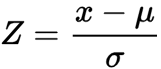

In [9]:
"""""
Remove Outliers based on Z-score

--Variables of Interest--
clean_prod_list: List of Separate Dataframes for each 
                Category Product Due to Different Number of Rows Removed
"""""


#Create list for later Visualizations
clean_prod_list = []

#Remove Outliers based on Z-score on new filtered sales DF
for col in prod_sales_df.columns:
    clean_cat_df = prod_sales_df[col].reset_index()
    
    #Find Rows where z-value < 3
    z_score =  np.abs(stats.zscore(prod_sales_df[col]))
    clean_cat_df = clean_cat_df.set_index(z_score).rename_axis(None, axis=1).rename_axis('z-score', axis=0)
    clean_cat_df = clean_cat_df[clean_cat_df.index < 2.7]
    #Drop z-score idx and set to date for further visualizations
    clean_cat_df = clean_cat_df.reset_index(drop=True).set_index('date')
    clean_cat_df.index = pd.to_datetime(clean_cat_df.index)
    
    #List of Cleaned DFs of Each Product
    clean_prod_list.append(clean_cat_df)
   
    print(f'Dropping {len(prod_sales_df) - len(clean_cat_df)} rows: {col}')

    ##CHECK
    ## Removing rows by index, where z-score > 3
    # z_outlier_idx = np.where(z_score>3)[0]
    # print(f"Dropping {len(z_outlier_idx)} Rows: {col} \n")

    ##Check Z-score idx's range
    # print(clean_cat_df.loc[~clean_cat_df.index.isin(z_outlier_idx)].idxmax())


Dropping 9 rows: BEVERAGES
Dropping 13 rows: BREAD/BAKERY
Dropping 13 rows: CLEANING
Dropping 11 rows: DAIRY
Dropping 11 rows: DELI
Dropping 12 rows: EGGS
Dropping 23 rows: FROZEN FOODS
Dropping 14 rows: GROCERY I
Dropping 17 rows: GROCERY II
Dropping 24 rows: HOME AND KITCHEN I
Dropping 14 rows: HOME CARE
Dropping 11 rows: LIQUOR,WINE,BEER
Dropping 4 rows: MEATS
Dropping 16 rows: PERSONAL CARE
Dropping 5 rows: POULTRY
Dropping 5 rows: PREPARED FOODS
Dropping 26 rows: PRODUCE
Dropping 4 rows: SEAFOOD


Note: Best to find which row by index to remove, and count index, comparing rows by dataframe more prone to error.

From our inital plots of each category, we expect that there are around a few outliers, and rows removed.

In [10]:
"""Average Daily Sales"""
#Avg Sales of Each column Across Entire Time
avg_daily_sales = prod_sales_df.apply(np.mean)
print("Avg Sales Across Time: \n", avg_daily_sales)

Avg Sales Across Time: 
 family
BEVERAGES             174053.505428
BREAD/BAKERY           28396.539226
CLEANING               63643.615199
DAIRY                  46293.733414
DELI                   16264.091504
EGGS                   10037.244873
FROZEN FOODS            9483.837655
GROCERY I             235291.503549
GROCERY II              1247.267793
HOME AND KITCHEN I      1667.861279
HOME CARE              15633.067551
LIQUOR,WINE,BEER        5114.123040
MEATS                  19285.484794
PERSONAL CARE          16885.756333
POULTRY                20997.699370
PREPARED FOODS          5614.665234
PRODUCE               119526.674169
SEAFOOD                 1245.135007
dtype: float64


In [11]:
"""Creating Quartiles to Drop 
Lowest Categories in Grouped Percentile"""

#identify lowest percentile cutoff
low, mid= np.percentile(avg_daily_sales,[33,66])

# print("Sales Percentiles:")
# print("{percent} \n".format(percent = [low,mid]))

#Get categories belonging to specific quantiles
low_cat = list( avg_daily_sales[avg_daily_sales.values <= low].index )
mid_cat = list( avg_daily_sales[ (avg_daily_sales.values >low) & (avg_daily_sales.values <= mid)].index )
high_cat = list(avg_daily_sales[avg_daily_sales.values > mid].index )

print(f"The low quartile categories are: \n {low_cat} \n")
print(f"The med quartile categories are: \n {mid_cat} \n")
print(f"The high quartile categories are: \n {high_cat} \n")

The low quartile categories are: 
 ['FROZEN FOODS', 'GROCERY II', 'HOME AND KITCHEN I', 'LIQUOR,WINE,BEER', 'PREPARED FOODS', 'SEAFOOD'] 

The med quartile categories are: 
 ['DELI', 'EGGS', 'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY'] 

The high quartile categories are: 
 ['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'GROCERY I', 'PRODUCE'] 



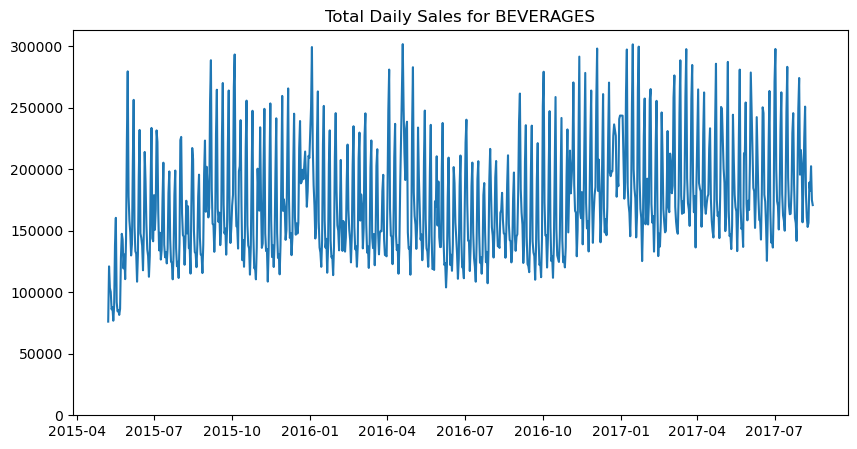

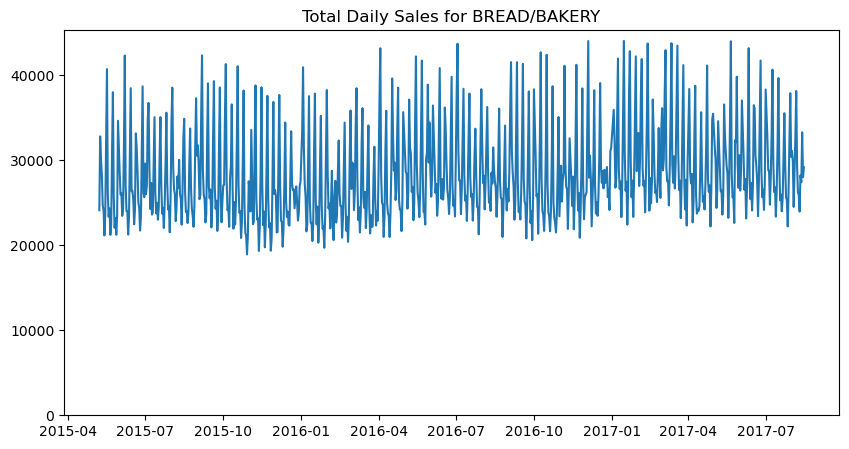

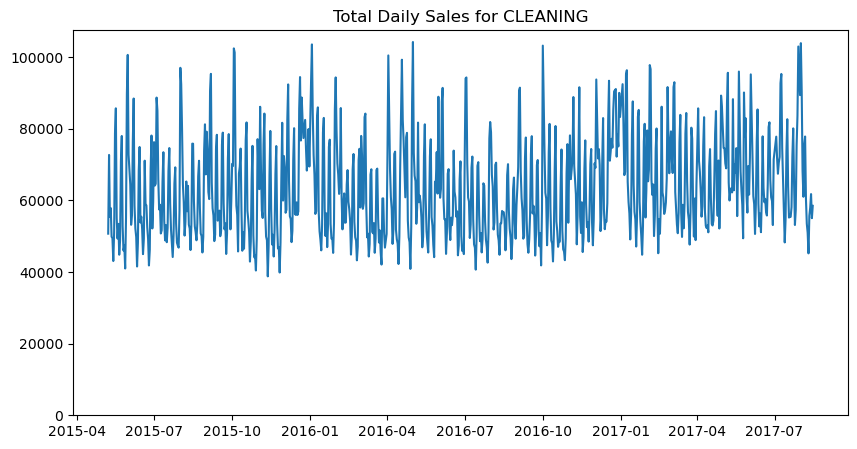

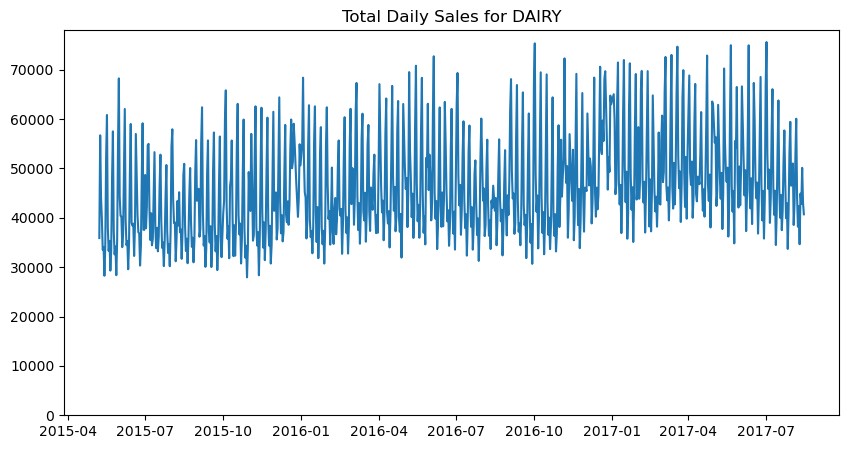

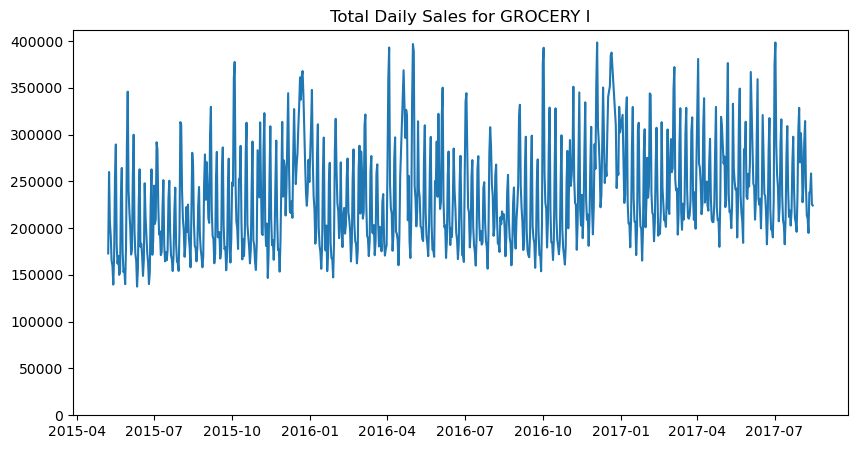

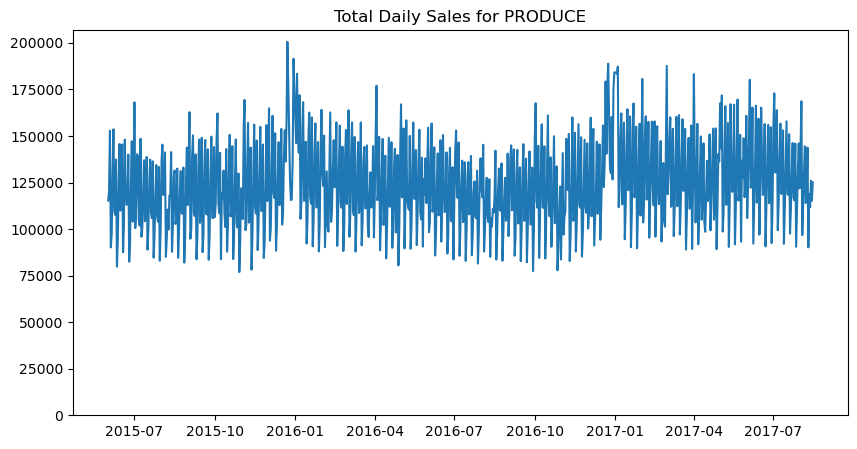

In [12]:
"""
Visualizations of Cleaned High Percentile Categories

--Variables of Interest--
    clean_prod_list: List of Cleaned DFs of Each Product (w/o Low Volume and Outliers)
    high_cat: List of Category Product Names
"""
#Can Change and Customize DFS Product Categories of Interest
for cat_df in clean_prod_list:
    #Selecting high percentile categories
    prod_list = cat_df.columns.to_list()
    #Select Specific high category problems from
    if  set(prod_list).intersection(high_cat):
        plt.gcf().set_size_inches(10, 5)

        plt.plot(cat_df.index, cat_df)
        plt.title(f"Total Daily Sales for {cat_df.columns[0]}")
        plt.ylim(0)
        plt.show()
   

### Optimization with Hyperparameter Tuning
For further hyperparameter tuning, we can change some factors from our chosen prepreocessed category's data for more reliable predictions, improving MAPE scores while after determining best hyperparameters with cross-validation.

1. **Impute or Drop Missing Values**

    For dataframe *Liquor, Wine and Beer*, from the plot visualizations when included we notice the many 0 total sales in the earlier years. We can either *impute* or *drop* the missing/null values. We can assume that either there were actually 0 sales or that those sales were not as recorded as diligently in earlier years. We assume the latter, but will test both to determine if there's performance in improvement.


2. **Adjust Z-score values when identifying Outliers (average sales of each product)**

    We can choose to exclude data points where it is 2.5-3 Standard Deviations Far from the Mean.


#### Hyperparameter Tuning Pipeline of Multiple Product Categories

In [16]:
"""
Prepare Historical Train Data --> ds, y columns

--Variables of Interest--
high_cat: List of Category Names
high_prod_list: List of DFs from Chosen Categories
train_set_df: Filtered Dates of each DFs in high_prod_list
"""""

#Create ds,yhat for each
forecast_date = date(2017,7,1) #2017-08-15 is last date of dataset --> forecasting on that day forward

#List of Dataframes of High Percentile Group Category Products List 
clean_prod_list_copy = clean_prod_list.copy()
high_prod_list = [df.reset_index() for df in clean_prod_list_copy if df.columns in high_cat]
train_set_df= []

#If Category Product DF is in our High Percentile Group 
for cat_df in high_prod_list:
        #Prepare Historical Train Data --> ds, y columns
        date_cat_df= cat_df[cat_df['date'] < '2017-07-01']
        train_set_df.append(date_cat_df)
train_set_df

[          date  BEVERAGES
 0   2015-05-08    76100.0
 1   2015-05-09   120977.0
 2   2015-05-10   103419.0
 3   2015-05-11   100265.0
 4   2015-05-12    86067.0
 ..         ...        ...
 769 2017-06-26   166889.0
 770 2017-06-27   140339.0
 771 2017-06-28   143776.0
 772 2017-06-29   136268.0
 773 2017-06-30   170346.0
 
 [774 rows x 2 columns],
           date  BREAD/BAKERY
 0   2015-05-08   24110.00802
 1   2015-05-09   32789.78498
 2   2015-05-10   29973.03803
 3   2015-05-11   28182.19100
 4   2015-05-12   24670.50700
 ..         ...           ...
 766 2017-06-26   28669.22300
 767 2017-06-27   25639.12502
 768 2017-06-28   26531.13500
 769 2017-06-29   24142.70603
 770 2017-06-30   27596.80010
 
 [771 rows x 2 columns],
           date  CLEANING
 0   2015-05-08   50705.0
 1   2015-05-09   72681.0
 2   2015-05-10   55371.0
 3   2015-05-11   57848.0
 4   2015-05-12   49852.0
 ..         ...       ...
 768 2017-06-26   65705.0
 769 2017-06-27   60870.0
 770 2017-06-28   59831.0
 7

#### Ranges Given on Prophet's Documentation

    - changepoint_prior_scale [0.001, 0.5]
    - seasonality_prior_scale [0.01, 10]
    - holidays_prior_scale [0.01, 10]
    - seasonality_mode ['additive', 'multiplicative'].
    - changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [453]:
"""""
Hyperparameter Tuning and Select Best Parmeters

--Variables of Interest -- 
prod_best_param : Dictionary of dictionaries where {key --> 'Product Name : value --> Best Hyperparameters } 
                Ex: { {'Bread' : {change_point_prior_scale: [.01,10] } , {'Dairy': } , .... }

"""""
#Takes 1 hr 31 Minutes to run
start_time = time.time()

#Dict of Each Produce Name and Best Hyperparameters
prod_best_param = {}
param_grid = {  
    'changepoint_prior_scale': list(np.linspace(.001, .5, num=5)),
    'seasonality_prior_scale': list(np.linspace(.01, 10, num=5))
    # 'seasonality_mode': ['additive', 'multiplicative']
    # 'changepoint_range': list(np.linspace(0.5, 0.95, num=5))
    }

#If Category Product DF is in our High Percentile Group 
for cat_df in high_prod_list:
    #Rename Product DF Columns
    prod_name = cat_df.columns[1]
    train_set_df_tune = cat_df.rename(columns={prod_name: 'y', 'date': 'ds'})

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(train_set_df_tune)  # Fit model with given params
        df_cv = cross_validation(m, initial=365, period='30 days', horizon = '30 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        mapes.append(df_p['mape'].values[0])


    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mape'] = mapes
    #Selecting best param with lowest MAPE
    best_params = tuning_results.sort_values('mape').iloc[0]
    best_params = best_params.to_dict()   

    #Save best parameters for that Product Category
    prod_best_param[prod_name] = best_params

run_time = time.time() - start_time
print('--- HyperparamTuning took {run_time}----')

19:14:29 - cmdstanpy - INFO - Chain [1] start processing
19:14:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:14:46 - cmdstanpy - INFO - Chain [1] start processing
19:14:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:15:31 - cmdstanpy - INFO - Chain [1] start processing
19:15:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:15:53 - cmdstanpy - INFO - Chain [1] start processing
19:15:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:16:15 - cmdstanpy - INFO - Chain [1] start processing
19:16:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has per

--- HyperparamTuning took {run_time}----


In [454]:
prod_best_param

{'BEVERAGES': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.1311209349989168},
 'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.07843758200416558},
 'CLEANING': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.12770761680806814},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.09908226670565227},
 'GROCERY I': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.13258801680640306},
 'PRODUCE': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.08215824653238614}}

### Finalized PROPHET Time Series Model

In [455]:
#Not Needed in PROPHET
def mape(y_actual, y_pred): 
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

In [456]:
"""
Create holiday data: 
"""
#Initalize holiday df
holiday_df = pd.DataFrame()

#For all days between 2015-2018, create holiday with specificed columns, concatenate
for date_, holiday_name in sorted(holidays.EC(years=[2015, 2016,2017, 2018]).items()): 
    # print(date_, holiday_name)
    one_holiday = pd.DataFrame([{
    'holiday': holiday_name,
    'ds': pd.to_datetime(date_),
    'lower_window': -2,
    'upper_window': 2,
    }])
    holiday_df = pd.concat([holiday_df,one_holiday]).sort_values('ds')
holiday_df.head()

,holiday,ds,lower_window,upper_window
0,Año Nuevo,2015-01-01,-2,2
0,Carnaval,2015-02-16,-2,2
0,Carnaval,2015-02-17,-2,2
0,Viernes Santo,2015-04-03,-2,2
0,Día del Trabajo,2015-05-01,-2,2


Prophet: It is based on an additive model where non-linear trends are fit to time series data. It decomposes the time series into trend, seasonality, and holiday components and models them separately. We will show different time components as well as the forecasted values in plots for each category.

20:45:38 - cmdstanpy - INFO - Chain [1] start processing
20:45:38 - cmdstanpy - INFO - Chain [1] done processing


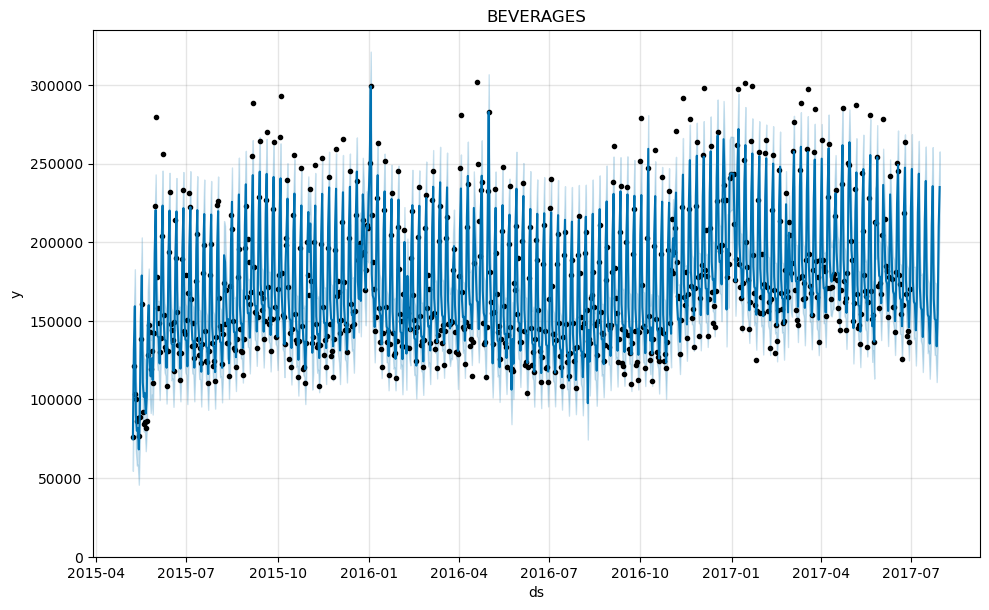

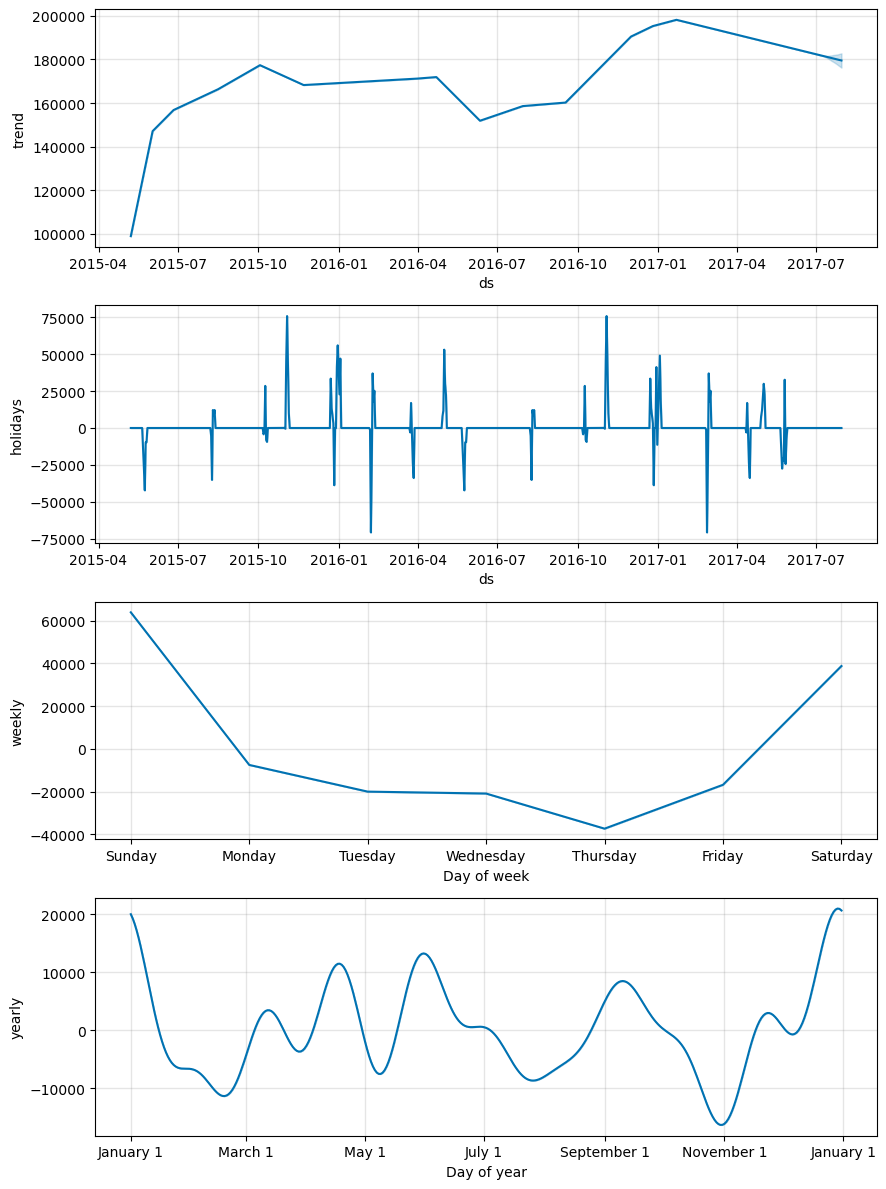

20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing


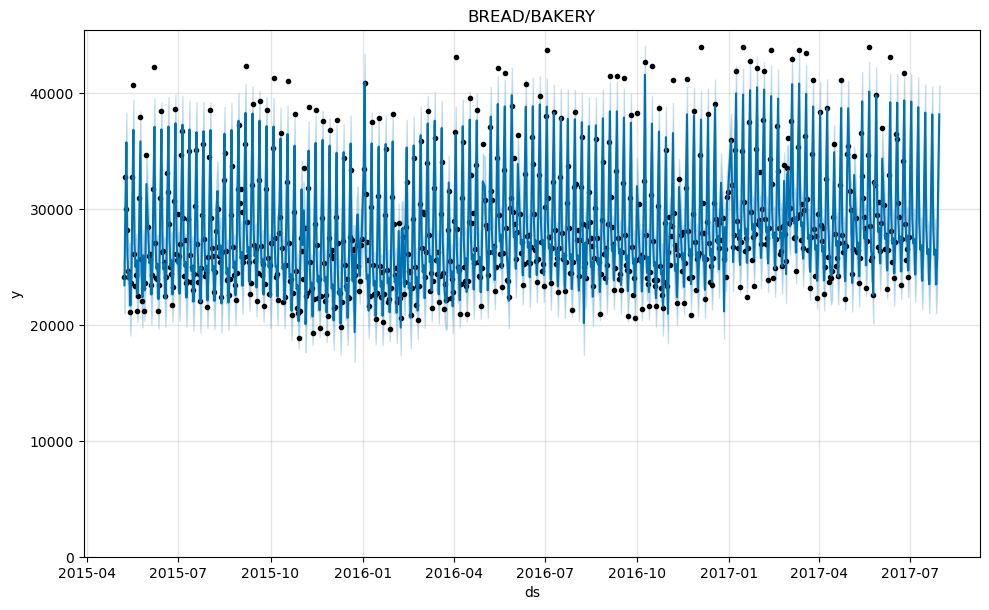

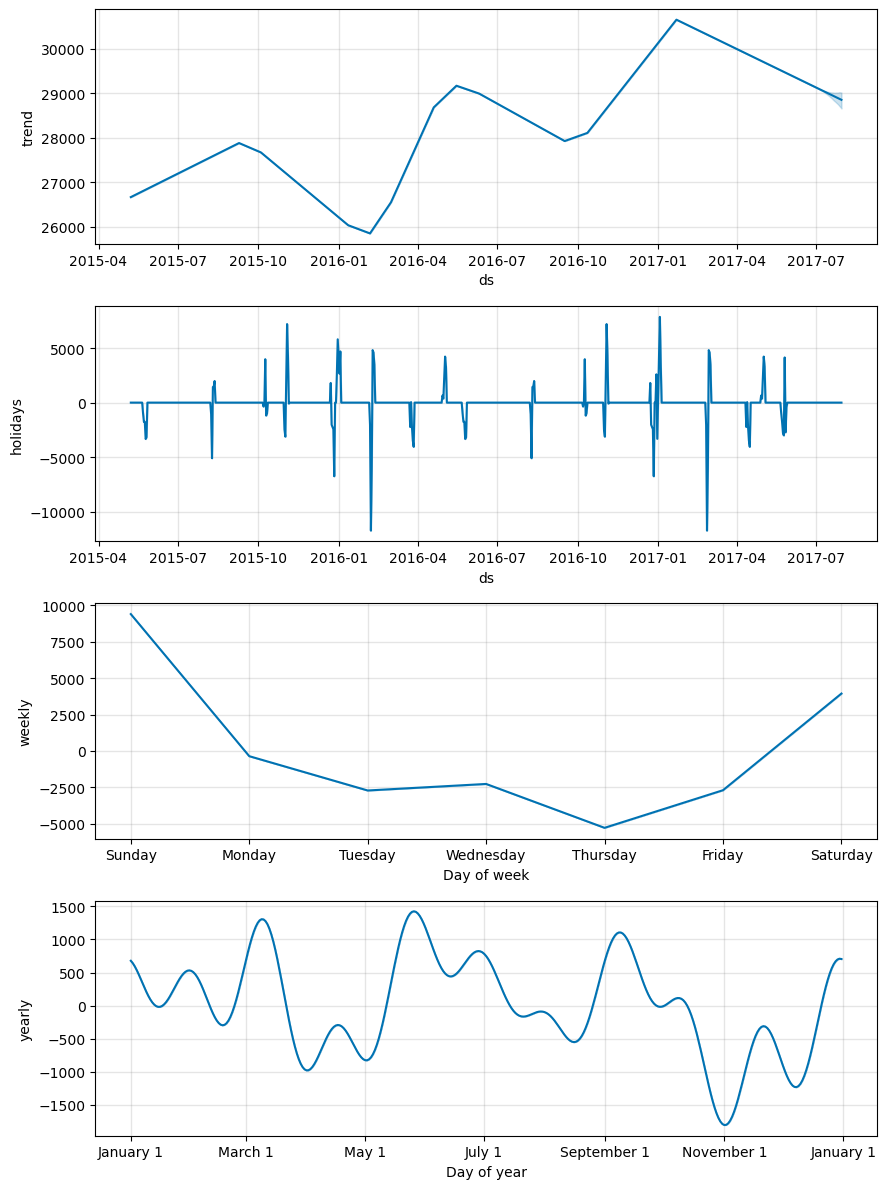

20:45:47 - cmdstanpy - INFO - Chain [1] start processing
20:45:47 - cmdstanpy - INFO - Chain [1] done processing


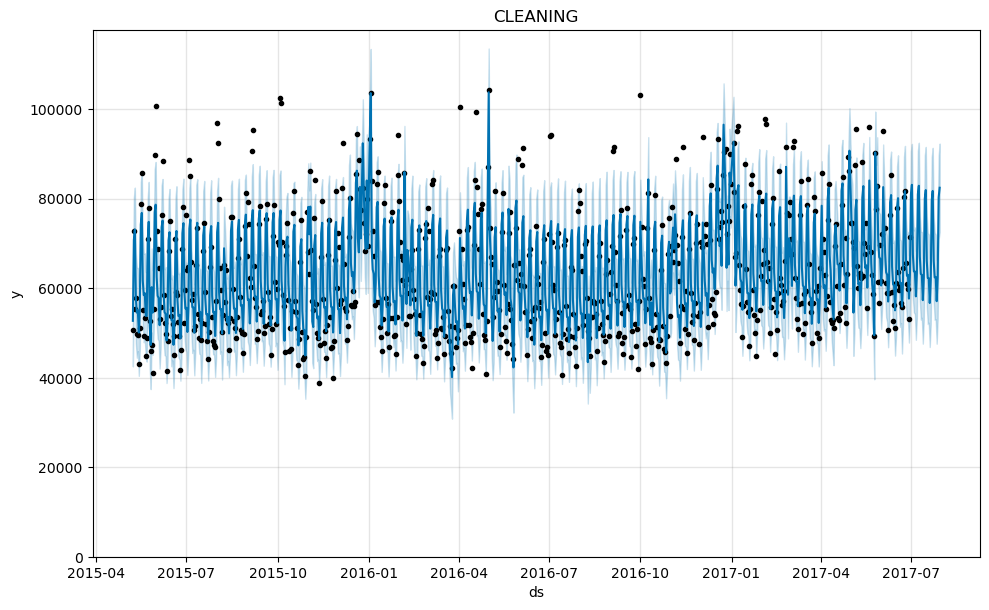

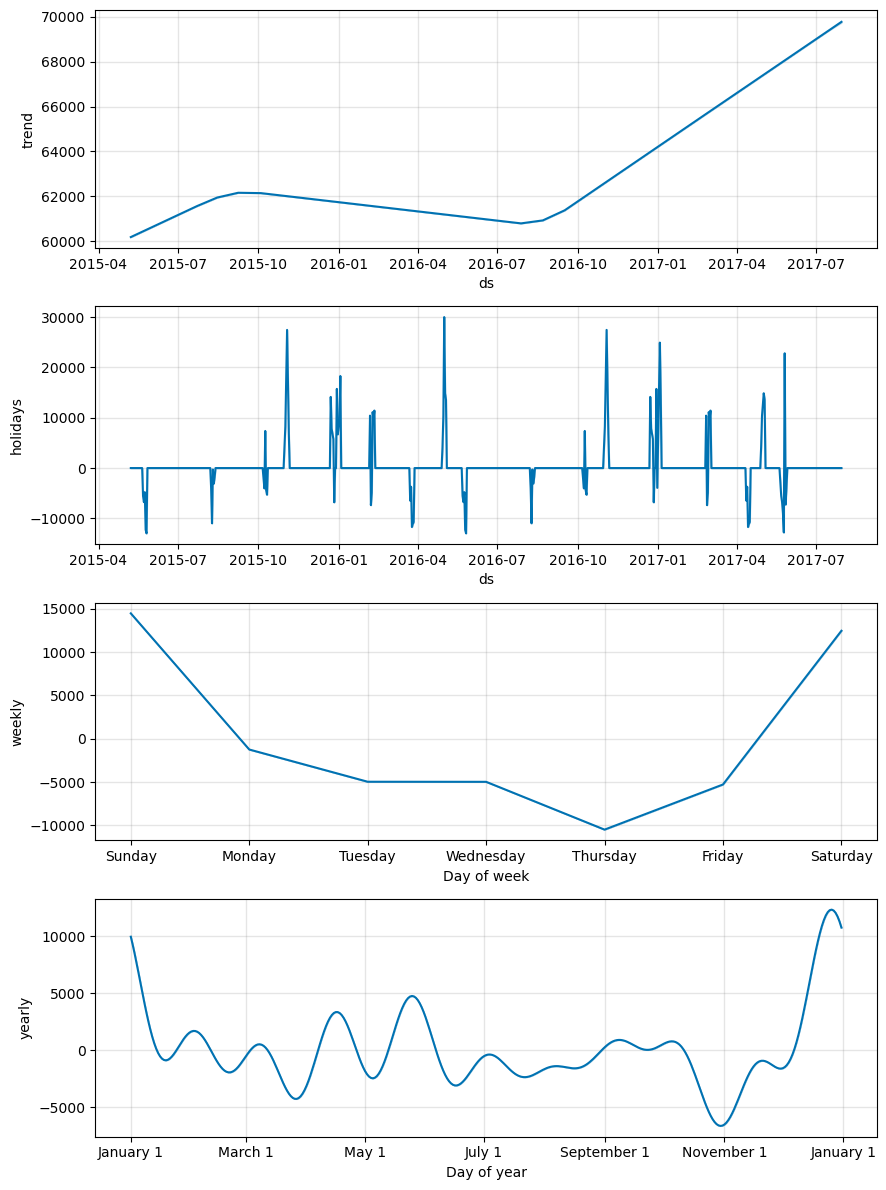

20:45:51 - cmdstanpy - INFO - Chain [1] start processing
20:45:51 - cmdstanpy - INFO - Chain [1] done processing


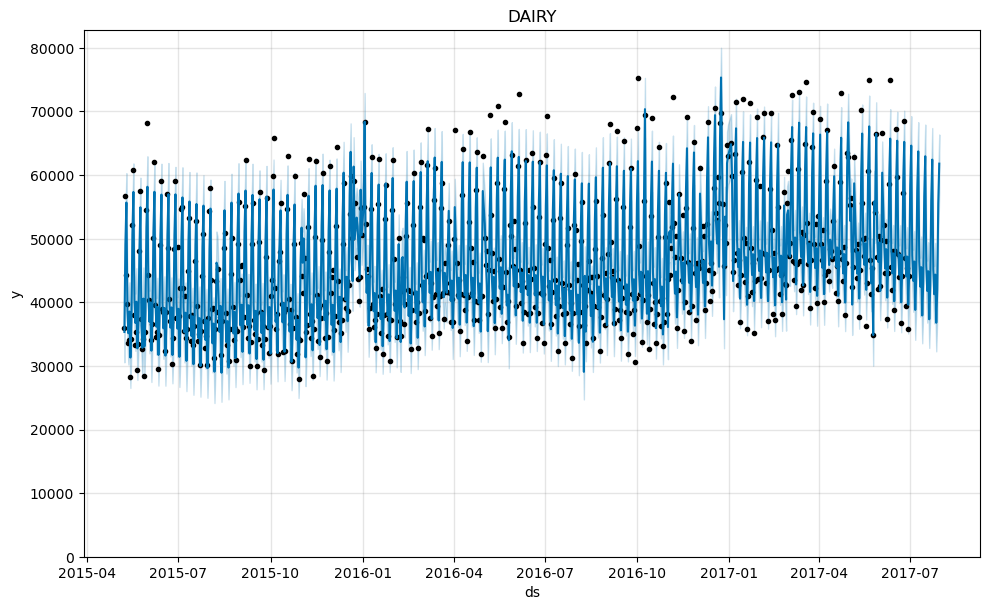

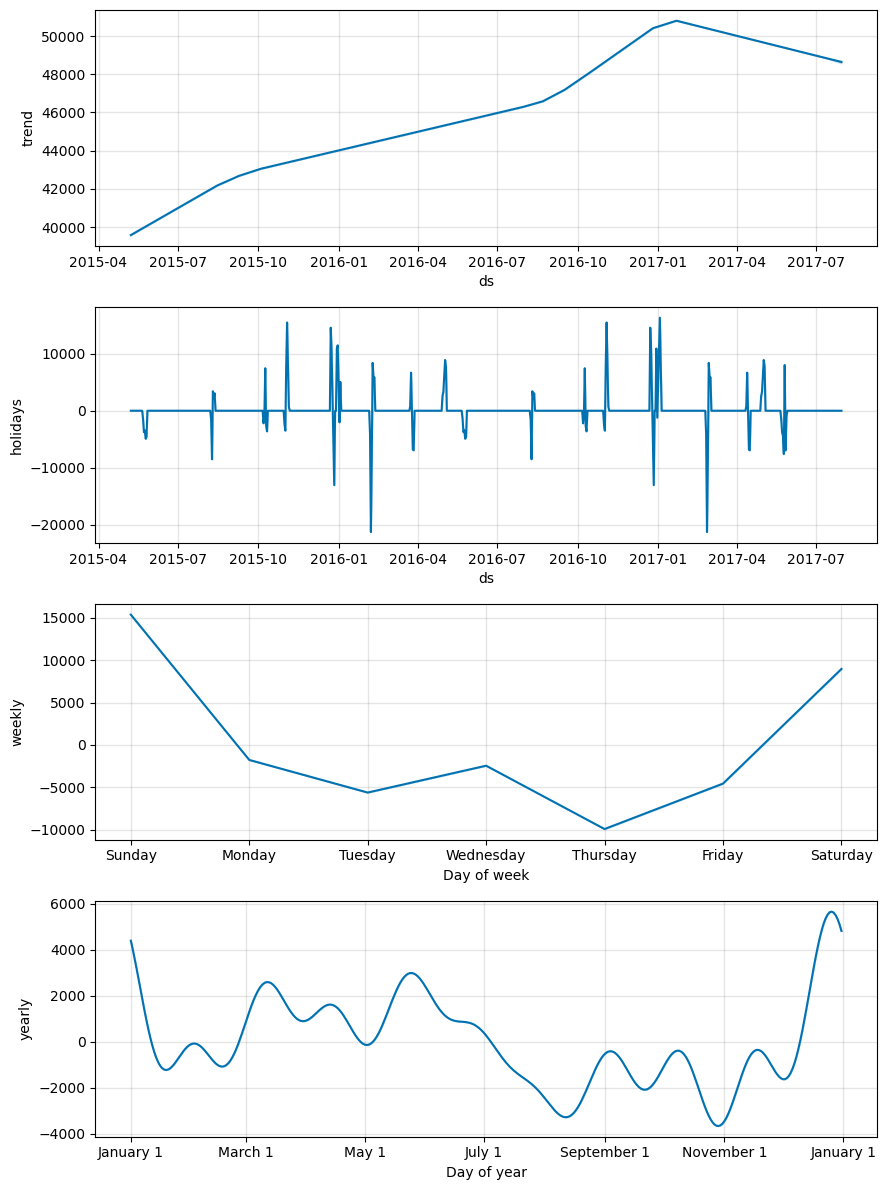

20:45:56 - cmdstanpy - INFO - Chain [1] start processing
20:45:56 - cmdstanpy - INFO - Chain [1] done processing


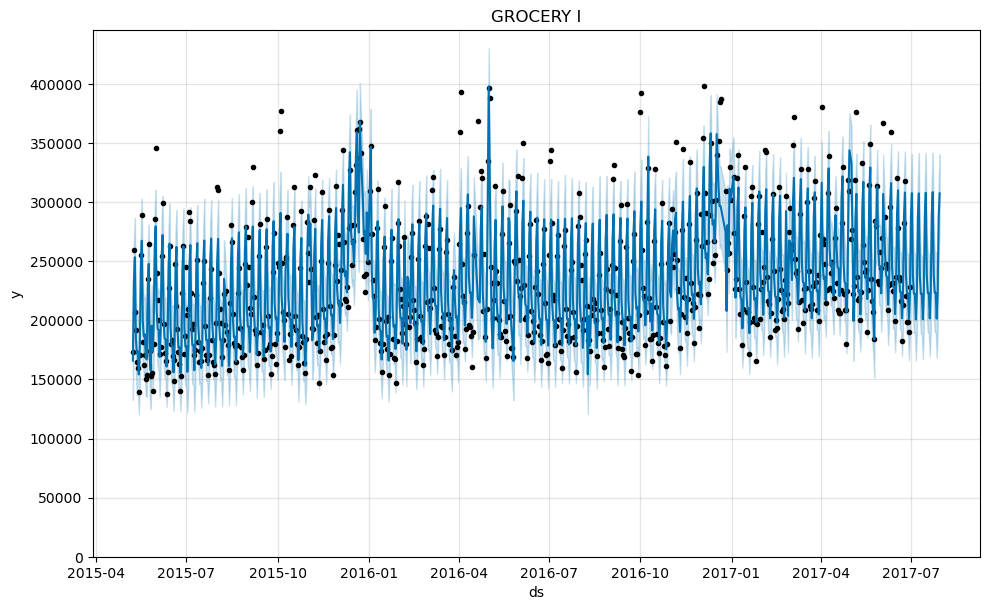

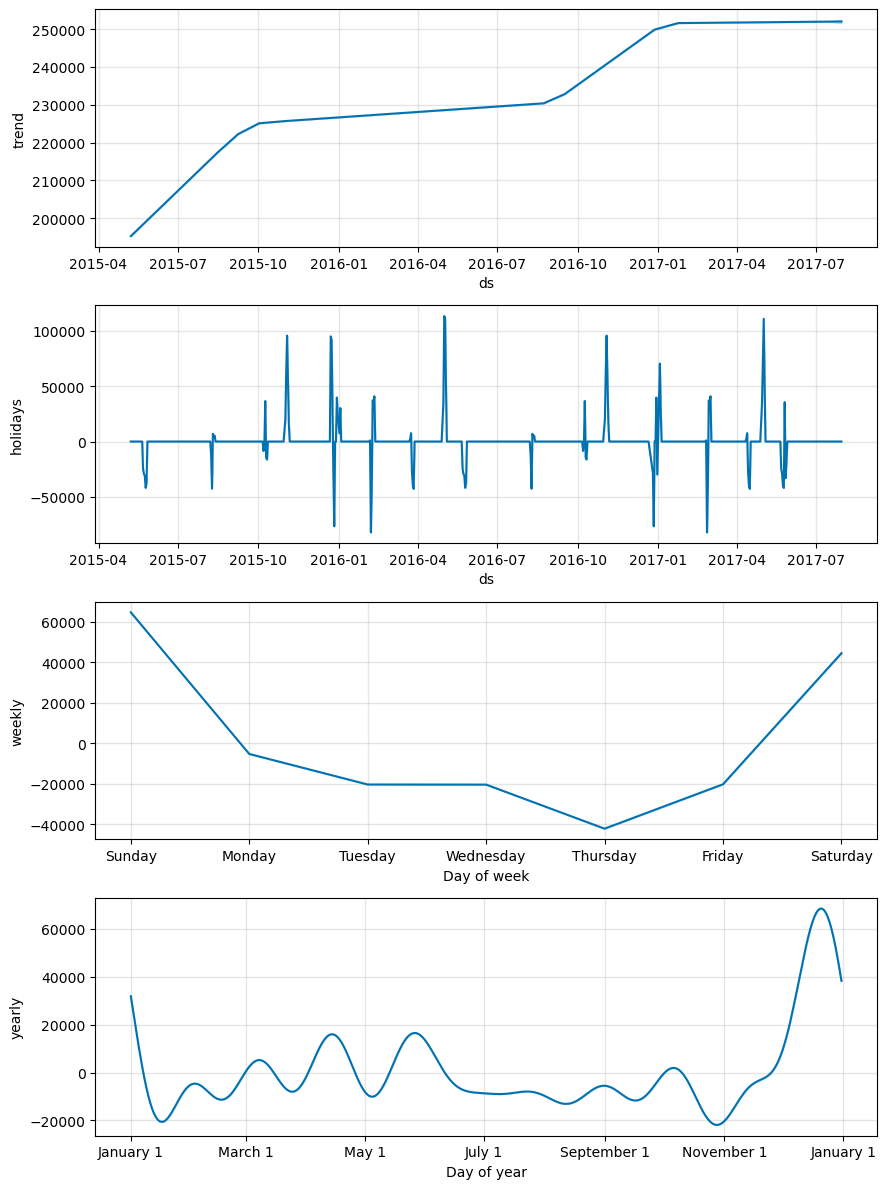

20:46:00 - cmdstanpy - INFO - Chain [1] start processing
20:46:00 - cmdstanpy - INFO - Chain [1] done processing


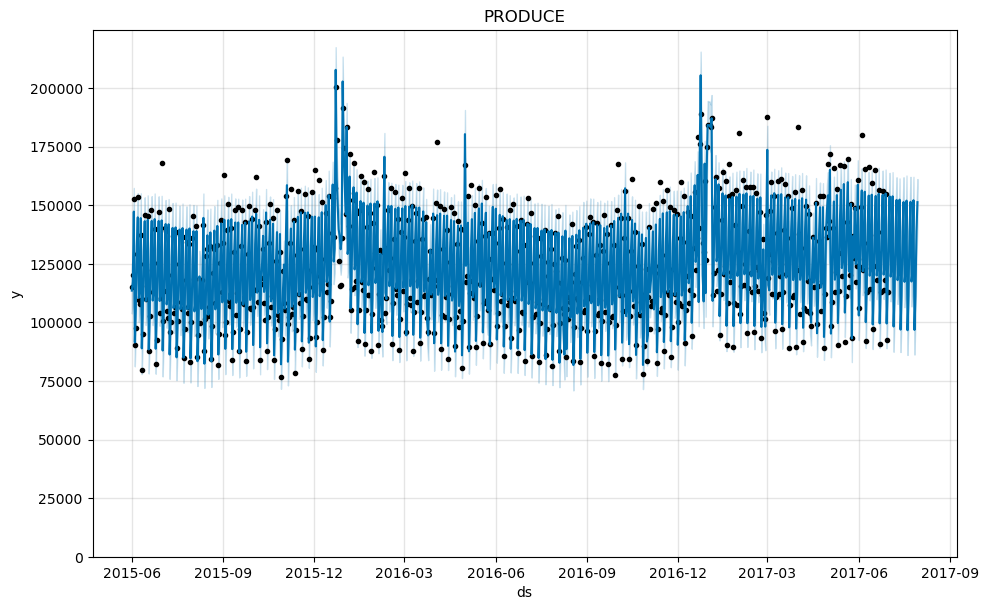

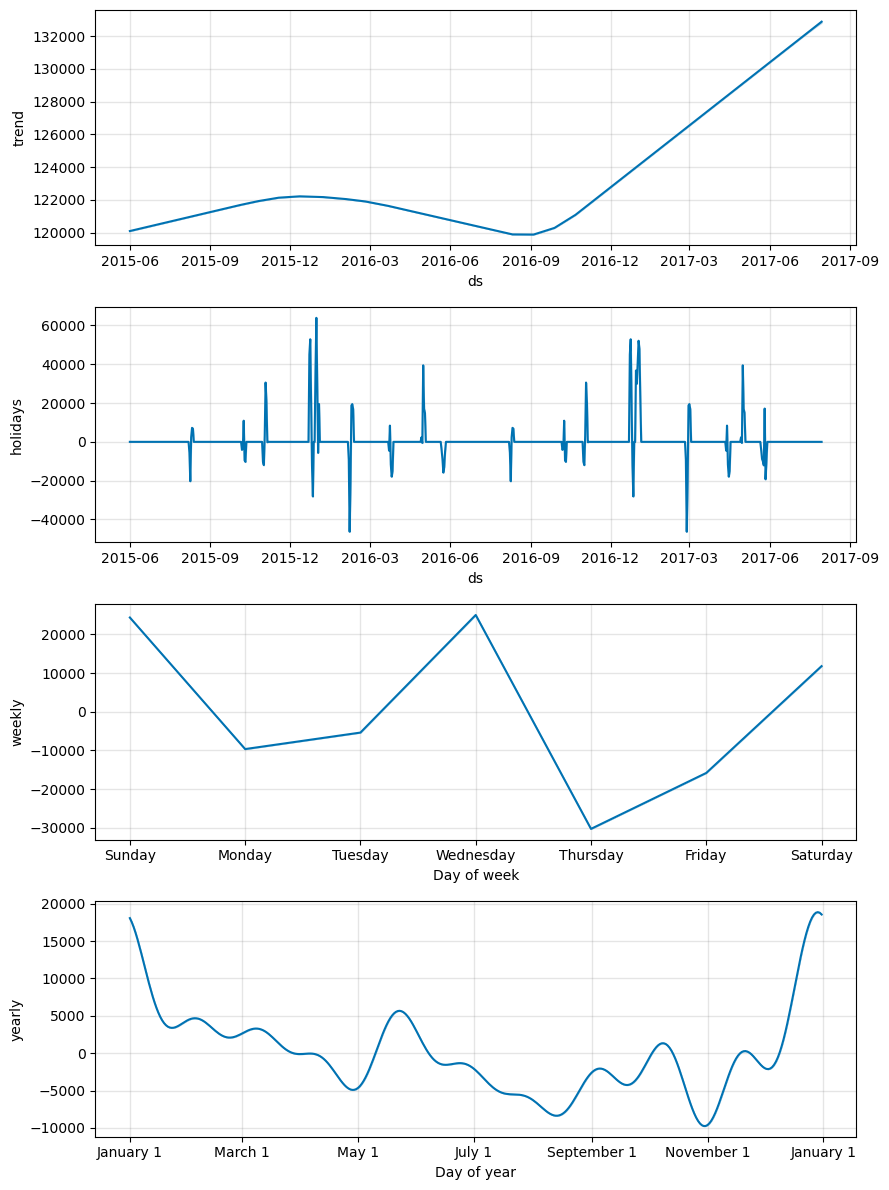

In [457]:
"""
Predict 30 days after July 1, 2017 and Plot Trends
"""
from prophet.plot import plot, plot_components
from matplotlib import pyplot as plt

#Actual Sales data of forecasted time
prod_sales_copy = prod_sales.reset_index()
actual_values = prod_sales_copy[(prod_sales_copy['date'] >= '2017-07-01')]

for cat_df in train_set_df:
    prod_name = cat_df.columns[1]
    
    train_set_df = cat_df[ (cat_df['date'] < '2017-07-01') ]
    train_set_df= train_set_df.rename(columns={prod_name: 'y', 'date': 'ds'})

    #Fit PROPHET Model with Historical Data
    fin_m = Prophet(holidays = holiday_df, yearly_seasonality = True, 
                    changepoint_prior_scale = prod_best_param[prod_name]['changepoint_prior_scale'], 
                    seasonality_prior_scale = prod_best_param[prod_name]['seasonality_prior_scale'])
    
    fin_m.fit(train_set_df)

    #Make Future Dataframe, Including Historical Dates  --> Specify future forecast period from historical data
    predicted_days = 30
    fin_future_df = fin_m.make_future_dataframe(periods = predicted_days)
    fin_forecast = fin_m.predict(fin_future_df)

   
    plot(fin_m, fin_forecast)  
    plt.title(prod_name)
    plt.ylim(0)             # Plot the forecast
    plot_components(fin_m, fin_forecast)    # Plot the forecast components
    plt.show()

## Statistical Approach with SARMIAX
SARMIAX (Seasonal Autoregressive Integrated Moving Average with exogenous variables) is a statistical model and another forecasting tool that can handle complex data patterns, seasonality, as well as as account for exogeneous factors. We can further explore and optimize this model. As PROPHET doesn't perform well in production, we can explore SARMIAX.

In [20]:
"""
Statistical Approach
"""
# import statsmodels.api as sm

# cat_df = train_set_df[0].set_index('date')
# prod_name = cat_df.columns[0]
# # Next, let's fit the SARIMAX model to the data
# model = sm.tsa.SARIMAX(cat_df[prod_name], order=(1, 0, 1), seasonal_order=(1, 1, 1, 365))
# result = model.fit()

# # Now, let's make the forecast for the next 30 days starting from July 1st
# forecast_start_date = '2017-07-01'
# forecast_end_date = pd.date_range(start=forecast_start_date, periods=30)

# # Generate the forecast
# forecast = result.get_forecast(steps=len(forecast_end_date))
# forecast_values = forecast.predicted_mean
# # print(forecast_values)

# # Select the actual sales data for the forecast period
# actual_sales_forecast_period = prod_sales_df[['date', prod_name]].loc[forecast_start_date:forecast_end_date]

# # Calculate the MAPE
# mape_score = mape(actual_sales_forecast_period, forecast_values)
# print("MAPE Score:", mape_score)

# # Plot diagnostics
# model.plot_diagnostics(figsize=(15, 10))
# plt.show()

# # Plot components
# fig = model.plot_components(figsize=(15, 10))
# plt.show()

c:\Users\cecil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cecil\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\cecil\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


KeyboardInterrupt: 